# TP3: Classification challenge
Author: Vadim Lebovici

## Introduction

#### Goal 
Your goal is to perform a supervised classification of a real-world dataset introduced in [this article](https://www.pnas.org/doi/10.1073/pnas.2102166118) which contains point clouds in $\mathbb{R}^2$ obtained from spatial locations of immune cells in tumours. The dataset contains three different types of immune cells:
- CD68 (65 point clouds with average of 560 points, minimum of 88 and maximum of 1000),
- CD8 (73 point clouds with average of 651 points, minimum of 194 and maximum of 1000),
- FoxP3 (74 point clouds with average of 211 points, minimum of 24 and maximum of 499).

You will find examples of point cloud for each class plotted below.

![Illustration of the dataset](../tp1/fig/dataset.png)

## Code

#### Data

In [7]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Extracting point clouds from data:

In [8]:
# Choose a number of samples for each cell type
# Toy classification to test your tools
n_CD68 = 5
n_CD8 = 5
n_FoxP3 = 5

# To get the full dataset, use the following numbers:
# n_CD68 = 73
# n_CD8 = 65
# n_FoxP3 = 74

In [ ]:
# Extracting point clouds from files
samplesCD68 = []
for i in range(n_CD68):
    df = pd.read_csv(f"./data/TumourT_CCD6810NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    samplesCD68.append(df)

samplesCD8 = []
for i in range(n_CD8):
    df = pd.read_csv(f"./data/TumourT_CCD810NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    samplesCD8.append(df)

samplesFoxP3 = []
for i in range(n_FoxP3):
    df = pd.read_csv(f"./data/TumourT_CFoxP310NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    samplesFoxP3.append(df)

Plotting examples of point clouds for each class:

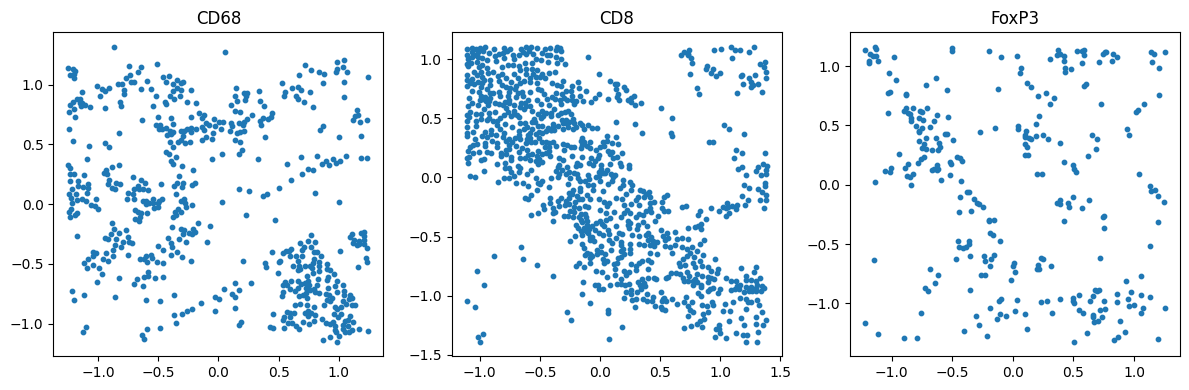

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot first sample of each class
axs[0].scatter(samplesCD68[0][:, 0], samplesCD68[0][:, 1], s=10)
axs[0].set_title('CD68')

axs[1].scatter(samplesCD8[0][:, 0], samplesCD8[0][:, 1], s=10)
axs[1].set_title('CD8')

axs[2].scatter(samplesFoxP3[0][:, 0], samplesFoxP3[0][:, 1], s=10)
axs[2].set_title('FoxP3')

plt.tight_layout()
plt.show()

Now we make a train/test split as required:

In [11]:
# Combine all point clouds into X and create corresponding labels y
X = samplesCD68 + samplesCD8 + samplesFoxP3
y = (
    [0] * len(samplesCD68) +  # Label 0 for CD68
    [1] * len(samplesCD8) +   # Label 1 for CD8
    [2] * len(samplesFoxP3)   # Label 2 for FoxP3
)

In [12]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Convert X and y to a numpy array for easier handling
X_array = np.array(X, dtype=object)  # dtype=object for arrays of different shapes
y_array = np.array(y)

# Shuffle X and y in unison
X_shuffled, y_shuffled = shuffle(X_array, y_array)

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, stratify=y_shuffled)

#### An example of very bad classification
To give you an example of classification pipeline, I will use summarize each point cloud by the coordinate of the barycenter of the point cloud, and use this vectorization for the classification task using a random forest classifier.

In [13]:
# Compute the barycenter (average coordinates) for each point cloud in X_train and X_test
vectorization_train = np.array([pc.mean(axis=0) for pc in X_train])
vectorization_test = np.array([pc.mean(axis=0) for pc in X_test])

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train RandomForest classifier
clf = RandomForestClassifier()
clf.fit(vectorization_train, y_train)

# Score on test set
vectorization_score = clf.score(vectorization_test, y_test)
print(f"Test accuracy: {vectorization_score:.2f}")

Test accuracy: 0.67


We get an accuracy between 30% and 40% which is close to the score 33% that we would obtain by guessing at random without any information. This shows that my choice of vectorization is very bad.

#### Example of solution using persistence images

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from gudhi import RipsComplex
from gudhi.representations import PersistenceImage

def compute_persistence_diagram(point_cloud):
    rips_complex = RipsComplex(points=point_cloud, max_edge_length=2.0)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    return simplex_tree.persistence_intervals_in_dimension(1)

def vectorize_diagrams(diagrams, resolution=(10, 10)):
    pi = PersistenceImage(resolution=resolution)
    pi.fit(diagrams)
    vectors = pi.transform(diagrams)
    return vectors

# Example usage
def classify_point_clouds(X_train, y_train, X_test, y_test):
    # Compute persistence diagrams
    train_diags = [compute_persistence_diagram(pc) for pc in X_train]
    test_diags = [compute_persistence_diagram(pc) for pc in X_test]

    # Vectorize with Persistence Images
    X_train_vec = vectorize_diagrams(train_diags)
    X_test_vec = vectorize_diagrams(test_diags)

    # Train classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_vec, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    return acc


In [ ]:
accuracy = classify_point_clouds(X_train, y_train, X_test, y_test)
print("Classification Accuracy:", accuracy)